In [266]:
from PIL import Image
import os
from glob import glob
from matplotlib import pyplot as plt
import cv2
import numpy as np

## Get all of the images in the same size so they can all be processed and given the same metrics and get the same effect

In [267]:
def standardize_image(image, target_height=600, target_width=900):
    # Get current dimensions
    height, width = image.shape[:2]
    
    # Calculate scaling factors for both dimensions
    height_scale = target_height / height
    width_scale = target_width / width
    
    # Use the smaller scaling factor to maintain aspect ratio
    scale = min(height_scale, width_scale)
    
    # Calculate new dimensions
    new_height = int(height * scale)
    new_width = int(width * scale)
    
    # Resize image
    standardized = cv2.resize(image, (new_width, new_height))
    
    # Create a black canvas of target size
    final_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    # Calculate positioning to center the image
    y_offset = (target_height - new_height) // 2
    x_offset = (target_width - new_width) // 2
    
    # Place the resized image in the center of the canvas
    final_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = standardized
    
    return final_image

## Preprocess the image
- Convert to LAB colour space to try get white colour to pop out more
- Apply CLAHE to try get teh colour enhancement and colour changes to stand out more
- gets colour difference by getting the median colour difference and seeing how much pixels vary from this to try get the white lines to stand out more.

In [268]:
def preprocess_image(img):
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0][0].set_title('Original Image')
    axes[0][0].axis('off')
    
    # Convert to LAB and show L channel
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    axes[0][1].imshow(l, cmap='gray')
    axes[0][1].set_title('L Channel')
    axes[0][1].axis('off')
    
    # Apply CLAHE and show enhanced L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced_l = clahe.apply(l)
    axes[0][2].imshow(enhanced_l, cmap='gray')
    axes[0][2].set_title('Enhanced L Channel (CLAHE)')
    axes[0][2].axis('off')
    
    # Show a and b channels
    axes[1][0].imshow(a, cmap='gray')
    axes[1][0].set_title('a Channel (Green-Red)')
    axes[1][0].axis('off')
    
    axes[1][1].imshow(b, cmap='gray')
    axes[1][1].set_title('b Channel (Blue-Yellow)')
    axes[1][1].axis('off')
    
    # Calculate and show color difference
    enhanced_lab = cv2.merge([enhanced_l, a, b])
    median_color = np.median(enhanced_lab.reshape(-1, 3), axis=0)
    amplification_factor = 5
    diff_channels = (enhanced_lab - median_color)*amplification_factor
    color_diff = np.sqrt(np.sum(diff_channels**2, axis=2))
    color_diff = cv2.normalize(color_diff, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    axes[1][2].imshow(color_diff, cmap='gray')
    axes[1][2].set_title('Final Color Difference')
    axes[1][2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return color_diff

## Get parking lines and cars and try to isolate parking lines.
- reads image in and erodes parking lines away so you only have the cars and noise.
- dilates cars and noise so they are around biig enough to resemble the cars in the original binary image.
- xors with original binary image to try get rid of cars and noise and only be left with car lines.

In [336]:
def detect_white_lines(img):
    # Convert to HSV for better white line detection
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define range for white color in HSV
    lower_white = np.array([0, 0, 155])#190
    upper_white = np.array([170, 30, 255])
    # Create mask for white colors
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    axes[0][0].imshow(white_mask, cmap='gray')
    axes[0][0].set_title('Original White Mask')
    axes[0][0].axis('off')
    
    # First create larger blobs to capture cars
    kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (9,5))
    car_blobs = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel_car, iterations=1)
    
    axes[0][1].imshow(car_blobs, cmap='gray')
    axes[0][1].set_title('Dilated Blobs')
    axes[0][1].axis('off')
    
    
    # Then erode to create gaps between lines and cars
    #kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (9,13))
    kernel_car = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    # set 1 car_blobs = cv2.morphologyEx(car_blobs, cv2.MORPH_DILATE, kernel_car, iterations=3)
    car_blobs = cv2.morphologyEx(car_blobs, cv2.MORPH_DILATE, kernel_car, iterations=5)
    
    axes[0][2].imshow(car_blobs, cmap='gray')
    axes[0][2].set_title('Eroded Blobs')
    axes[0][2].axis('off')
    
    # AND between original and inverted car blobs to keep only lines
    car_mask = cv2.bitwise_not(car_blobs)
    just_lines = cv2.bitwise_and(white_mask, car_mask)
    
    axes[1][0].imshow(car_mask, cmap='gray')
    axes[1][0].set_title('Car Mask (Inverted)')
    axes[1][0].axis('off')
    
    # Clean up the lines
    kernel_line = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    cleaned_lines = cv2.morphologyEx(just_lines, cv2.MORPH_CLOSE, kernel_line, iterations=20)
    
    
    axes[1][1].imshow(just_lines, cmap='gray')
    axes[1][1].set_title('Lines Only')
    axes[1][1].axis('off')
    
    axes[1][2].imshow(cleaned_lines, cmap='gray')
    axes[1][2].set_title('Cleaned Lines')
    axes[1][2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return just_lines

## Once we have parking lines isolated try to improve their visibility so cropping can take place. 
- Firstly blur the image to try minimise nosie.
- Carry out edge detection to impose teh parking lines and get rid of nosie that isn't a majopor edge. 
- Carry out hough transform to try and build lines and join themm together 
- Do dilation and erosion to make the lines stand out a little more before cropping. 
- I think detected parking spaces image doesn't do much for the image here

In [356]:
def detect_parking_lines(img):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
        
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    axes[0][0].imshow(edges, cmap='gray')
    axes[0][0].set_title('Edge Detection')
    axes[0][0].axis('off')
    
    # Use probabilistic Hough transform to detect lines
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi/180,
        threshold=20,#40 #20 medium
        minLineLength=40,  # Minimum length of line
        maxLineGap=50 #50      # Maximum gap between line segments
    )
    
    # Create separate images for horizontal and vertical lines
    horizontal_lines = np.zeros_like(gray)
    vertical_lines = np.zeros_like(gray)
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # Calculate line angle
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi)
            
            # Calculate line length
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
            # Classify lines based on angle
            if (angle < 20) or (angle > 160):  # Horizontal lines
                if length > 100:  # Filter by minimum length
                    cv2.line(horizontal_lines, (x1, y1), (x2, y2), 255, 2)
            elif (70 < angle < 110):  # Vertical lines
                if length > 50:  # Filter by minimum length
                    cv2.line(vertical_lines, (x1, y1), (x2, y2), 255, 2)
    
    axes[0][1].imshow(horizontal_lines, cmap='gray')
    axes[0][1].set_title('Horizontal Lines')
    axes[0][1].axis('off')
    
    axes[0][2].imshow(vertical_lines, cmap='gray')
    axes[0][2].set_title('Vertical Lines')
    axes[0][2].axis('off')
    
    # Combine horizontal and vertical lines
    combined_lines = cv2.bitwise_or(horizontal_lines, vertical_lines)
    
    # Clean up the lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    cleaned_lines = cv2.morphologyEx(combined_lines, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    axes[1][0].imshow(cleaned_lines, cmap='gray')
    axes[1][0].set_title('Combined Lines')
    axes[1][0].axis('off')
    
    # Find contours to identify parking spaces
    contours, _ = cv2.findContours(cleaned_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area and aspect ratio
    parking_spaces = np.zeros_like(gray)
    min_area = 1000
    
    if contours:
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > min_area:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = float(w)/h
                # Check if the aspect ratio is reasonable for a parking space
                if 0.8 < aspect_ratio < 1:
                    cv2.drawContours(parking_spaces, [contour], -1, 255, 2)
    
    axes[1][1].imshow(parking_spaces, cmap='gray')
    axes[1][1].set_title('Detected Parking Spaces')
    axes[1][1].axis('off')
    
    # Hide unused subplot
    axes[1][2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return cleaned_lines

In [330]:
def get_birds_eye_view(image):
    """
    Apply perspective transform to cropped parking area with adjusted points
    """
    height, width = image.shape[:2]
    
    # Adjusted source points for your specific image
    src_points = np.float32([
        [0, height-10],       # Bottom left (slight adjustment for misalignment)
        [width-1, height], # Bottom right (slight adjustment for misalignment)
        [width * 0.90, 5],    # Top right (adjusted for stronger perspective on right)
        [0+5, 5]     # Top left (adjusted for your image)
    ])
    
    # Destination points - making a perfect rectangle
    dst_points = np.float32([
        [0, height-1],        # Bottom left
        [width-1, height-1],  # Bottom right
        [width-1, -30],         # Top right
        [0, 0]                # Top left
    ])
    
    # Calculate and apply transform
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(image, matrix, (width, height))
    
    return warped

## Crop image to only detect parking spaces
Try crop the parking regions out based on the vertiical and horizontal lines that have been created in the previous method so we are only left with parking spaces and cars it should be alot easier to then see the occupancy of parkking spaces. 

In [329]:
def crop_parking_regions(parking_area, original_img):
    height, width = parking_area.shape[:2]
    padding_y = 0
    padding_x = 20
    
    # Get projections
    horizontal_projections = np.sum(parking_area, axis=1)
    vertical_projections = np.sum(parking_area, axis=0)
    
    # Normalize projections
    horizontal_projections = horizontal_projections / width
    vertical_projections = vertical_projections / height
    
    # Find significant horizontal lines
    horizontal_lines = np.where(horizontal_projections > 0.15)[0]
    vertical_lines = np.where(vertical_projections > 0.15)[0]
    
    # Group horizontal lines by proximity
    grouped_lines = []
    current_group = [horizontal_lines[0]]
    
    for i in range(1, len(horizontal_lines)):
        if horizontal_lines[i] - horizontal_lines[i-1] < 20:
            current_group.append(horizontal_lines[i])
        else:
            grouped_lines.append(current_group)
            current_group = [horizontal_lines[i]]
    grouped_lines.append(current_group)
    
    # Create regions from groups
    crop_coordinates = []  # Store the coordinates for cropping
    min_region_height = height * 0.15
    
    # Find x boundaries using vertical lines - do this once for all crops
    x_start = max(0, vertical_lines[0] - padding_x)
    x_end = min(width, vertical_lines[-1] + padding_x)
    
    for i, group in enumerate(grouped_lines):
        if i == 0 or i == len(grouped_lines) - 1:  # Top or bottom region
            start = max(0, min(group) - padding_y)
            end = min(height, max(group) + padding_y)
            if end - start > min_region_height:
                crop_coordinates.append((start, end, x_start, x_end))
        else:  # Middle groups - check height to filter out arrows
            start = max(0, min(group) - padding_y)
            end = min(height, max(group) + padding_y)
            if end - start > height * 0.2:
                crop_coordinates.append((start, end, x_start, x_end))
    
    # Create figure with enough subplots for both binary and original crops
    num_regions = len(crop_coordinates)
    fig = plt.figure(figsize=(15, 5 * num_regions))
    
    binary_crops = []
    original_crops = []
    
    for i, (y_start, y_end, x_start, x_end) in enumerate(crop_coordinates):
        # Create crops using the same coordinates for both
        binary_crop = parking_area[y_start:y_end, x_start:x_end]
        original_crop = original_img[y_start:y_end, x_start:x_end].copy()  # Make a copy to avoid reference issues
        
        binary_crops.append(binary_crop)
        original_crops.append(original_crop)
        
        # Create side-by-side plots
        # Binary crop (left side)
        ax1 = fig.add_subplot(num_regions, 2, 2*i + 1)
        ax1.imshow(binary_crop, cmap='gray')
        ax1.set_title(f'Region {i+1} - Binary\nSize: {binary_crop.shape}')
        ax1.axis('off')
        
        # Original crop (right side)
        ax2 = fig.add_subplot(num_regions, 2, 2*i + 2)
        ax2.imshow(cv2.cvtColor(original_crop, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'Region {i+1} - Original\nSize: {original_crop.shape}')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
        
    return binary_crops, original_crops, crop_coordinates

## Draw boxes around firstly the full parking spaces and then each indicviusal parking space and then we should be ready to see if the space is full or empty

In [354]:
def detect_parking_spaces(binary_crop, original_crop):
    height, width = binary_crop.shape[:2]
    
    # Calculate projections and normalize
    vertical_proj = np.sum(binary_crop, axis=0)
    horizontal_proj = np.sum(binary_crop, axis=1)
    vertical_proj = vertical_proj / np.max(vertical_proj)
    
    # Find peaks for vertical lines
    window_size = 15
    v_peaks = []
    for i in range(window_size, len(vertical_proj) - window_size):
        window = vertical_proj[i-window_size:i+window_size]
        if (vertical_proj[i] >= max(window) and 
            vertical_proj[i] > 0.3 and
            (not v_peaks or i - v_peaks[-1] >= 40)):
            v_peaks.append(i)
    
    # Add edge peaks if they're close to expected spacing
    if len(v_peaks) > 1:
        avg_spacing = np.mean([v_peaks[i+1] - v_peaks[i] for i in range(len(v_peaks)-1)])
        
        # Check left edge
        if v_peaks[0] > avg_spacing * 0.8:  # If there's room for a spot
            v_peaks.insert(0, 0)
            
        # Check right edge
        if (width - v_peaks[-1]) > avg_spacing * 0.8:  # If there's room for a spot
            v_peaks.append(width)
    
    # Find peaks for horizontal lines (single division line)
    h_threshold = 100000
    h_peaks = []
    
    for i in range(len(horizontal_proj)):
        if (horizontal_proj[i] > h_threshold and
            (not h_peaks or i - h_peaks[-1] >= 20)):
            h_peaks.append(i)
    
    # Draw visualization
    result = original_crop.copy()
    
    # Draw vertical and horizontal lines
    for x in v_peaks:
        cv2.line(result, (x, 0), (x, height), (0, 0, 255), 2)
    
    for y in h_peaks:
        cv2.line(result, (0, y), (width, y), (0, 0, 255), 2)
        
    spot_number = 1
    min_spot_width = 20  # Minimum width for a valid parking spot
    
    if len(h_peaks) > 0:  # If we have horizontal divisions
        for i in range(len(v_peaks)-1):
            x1, x2 = v_peaks[i], v_peaks[i+1]
            spot_width = x2 - x1
            
            # Skip if spot is too narrow
            if spot_width < min_spot_width:
                continue
                
            # Upper spot
            y1, y2 = 0, h_peaks[0]
            spot_height = y2 - y1
            aspect_ratio = spot_width / spot_height if spot_height > 0 else 0
            
            if 0.2 <= aspect_ratio <= 3.0 and spot_width >= min_spot_width:
                cv2.rectangle(result, (x1, y1), (x2, y2), (255, 165, 0), 2)
                cv2.putText(result, str(spot_number), 
                           ((x1 + x2)//2, (y1 + y2)//2),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 165, 0), 2)
                spot_number += 1
            
            # Lower spot
            y1, y2 = h_peaks[0], height
            spot_height = y2 - y1
            aspect_ratio = spot_width / spot_height if spot_height > 0 else 0
            
            if 0.2 <= aspect_ratio <= 3.0 and spot_width >= min_spot_width:
                cv2.rectangle(result, (x1, y1), (x2, y2), (255, 165, 0), 2)
                cv2.putText(result, str(spot_number), 
                           ((x1 + x2)//2, (y1 + y2)//2),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 165, 0), 2)
                spot_number += 1
    
    # Visualization
    fig, axes = plt.subplots(4, 1, figsize=(15, 16))
    
    axes[0].imshow(binary_crop, cmap='gray')
    axes[0].set_title('Binary Image')
    axes[0].axis('off')
    
    axes[1].plot(vertical_proj)
    axes[1].axhline(y=0.3, color='r', linestyle='--', label='Peak Threshold')
    axes[1].set_title('Vertical Projection')
    axes[1].legend()
    
    axes[2].plot(horizontal_proj)
    axes[2].axhline(y=h_threshold, color='r', linestyle='--', label='Threshold')
    axes[2].set_title('Horizontal Projection')
    axes[2].legend()
    
    axes[3].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axes[3].set_title('Detected Parking Spaces')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return v_peaks, h_peaks, result

In [274]:
def extract_parking_spots(original_img, v_peaks, h_peaks):
    height, width = original_img.shape[:2]
    parking_spots = []
    
    # Define vertical sections between consecutive v_peaks
    for i in range(len(v_peaks)-1):
        x1 = v_peaks[i]
        x2 = v_peaks[i+1]
        
        if len(h_peaks) == 0:
            # If no horizontal peaks, treat as one section
            spot = {
                'coords': (x1, 0, x2, height),
                'roi': original_img[0:height, x1:x2]
            }
            parking_spots.append(spot)
        else:
            # Create sections between horizontal lines
            y_sections = [0] + h_peaks + [height]
            for j in range(len(y_sections)-1):
                y1 = y_sections[j]
                y2 = y_sections[j+1]
                
                # Add spot if it has reasonable dimensions
                if (x2 - x1) > 20 and (y2 - y1) > 20:
                    spot = {
                        'coords': (x1, y1, x2, y2),
                        'roi': original_img[y1:y2, x1:x2]
                    }
                    parking_spots.append(spot)
    
    return parking_spots

In [275]:
def analyze_parking_spot_occupancy(original_crop, spots):
    results = []
    vis_img = original_crop.copy()
    
    for i, spot in enumerate(spots, 1):
        x1, y1, x2, y2 = spot['coords']
        spot_roi = spot['roi']
        
        h = spot_roi.shape[0]
        top_half = spot_roi[:h//2, :]
        bottom_half = spot_roi[h//2:, :]
        
        def analyze_half(half, side):
            gray = cv2.cvtColor(half, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 50, 150)
            variance = np.var(gray)
            mean_intensity = np.mean(gray)
            edge_density = np.sum(edges > 0) / (edges.size)
            print(f"Space {i} {side} - Variance: {variance:.2f}, Mean Intensity: {mean_intensity:.2f}, Edge density: {edge_density:.3f}")
            return variance > 600 and edge_density > 0.08
        
        print(f"\nAnalyzing Space {i}:")
        print("Top half:")
        top_occupied = analyze_half(top_half, "Top")
        print("Bottom half:")
        bottom_occupied = analyze_half(bottom_half, "Bottom")
        
        is_occupied = top_occupied and bottom_occupied
        
        color = (0, 0, 255) if is_occupied else (0, 255, 0)
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
        label = f"{i}: {'Occ' if is_occupied else 'Vac'}"
        cv2.putText(vis_img, label, (x1+5, y1+20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        results.append({
            'coords': (x1, y1, x2, y2),
            'occupied': is_occupied,
            'halves': {'top': top_occupied, 'bottom': bottom_occupied}
        })
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_crop, cv2.COLOR_BGR2RGB))
    plt.title('Original Crop')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title('Occupancy Analysis')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results, vis_img

# MAIN PROCESSING  LOOP

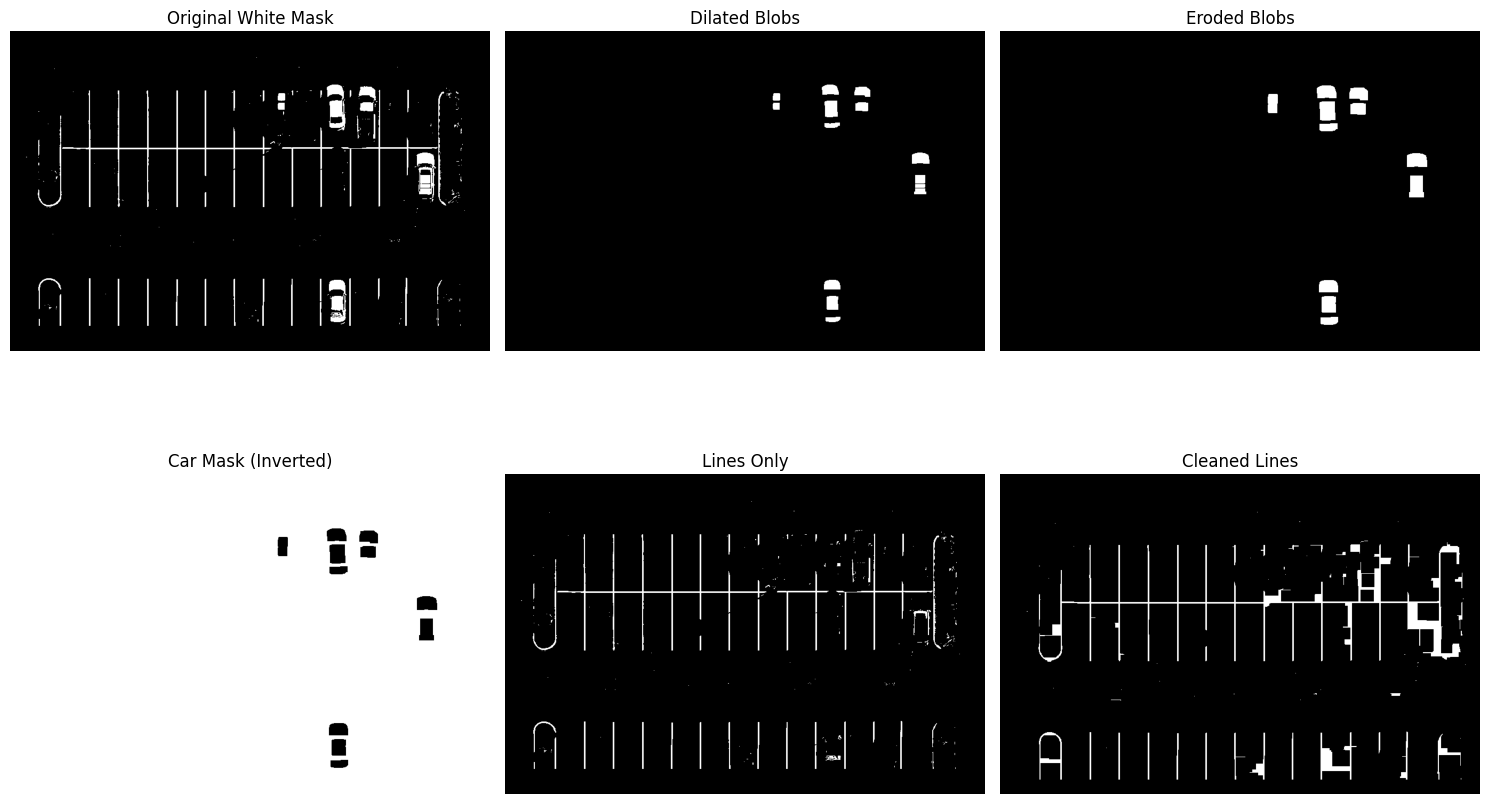

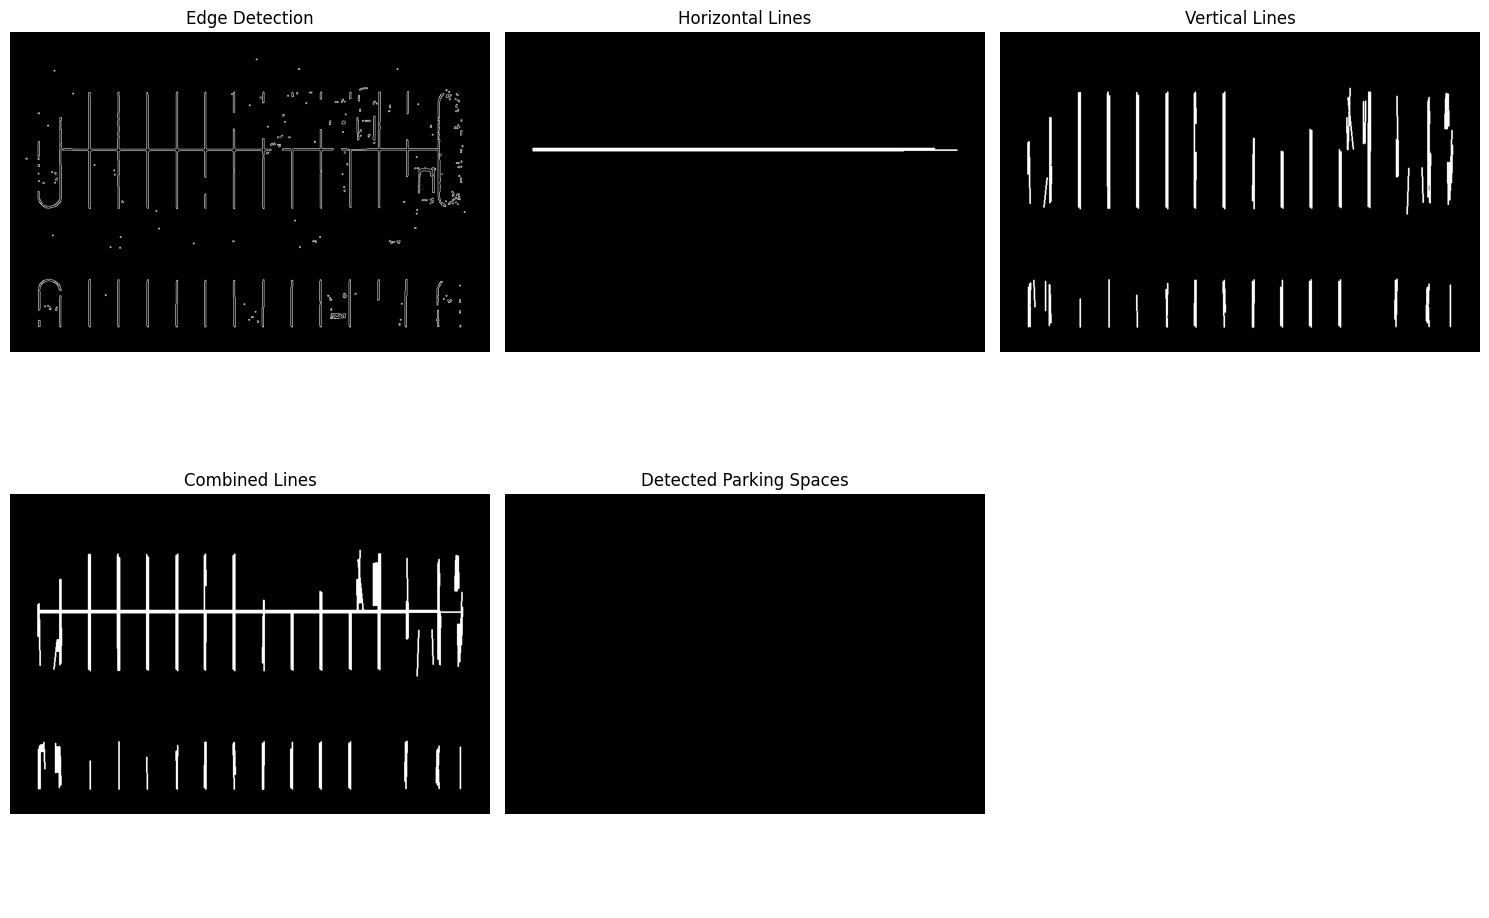

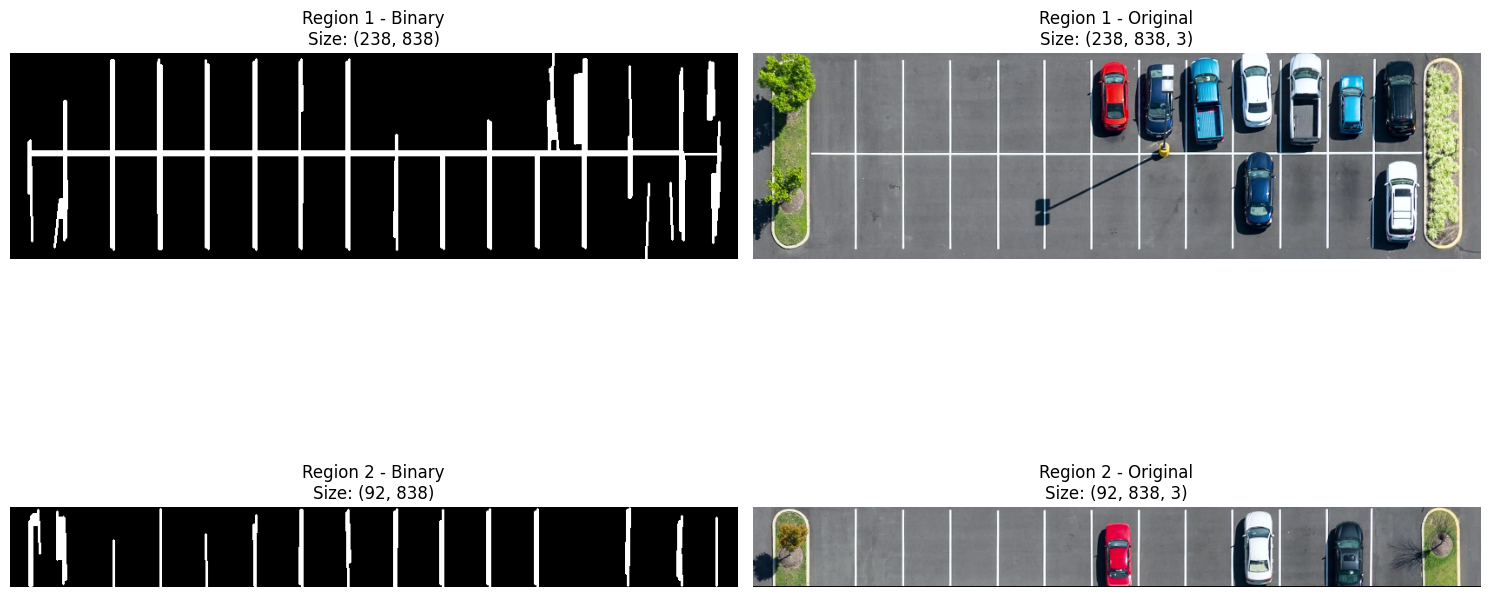

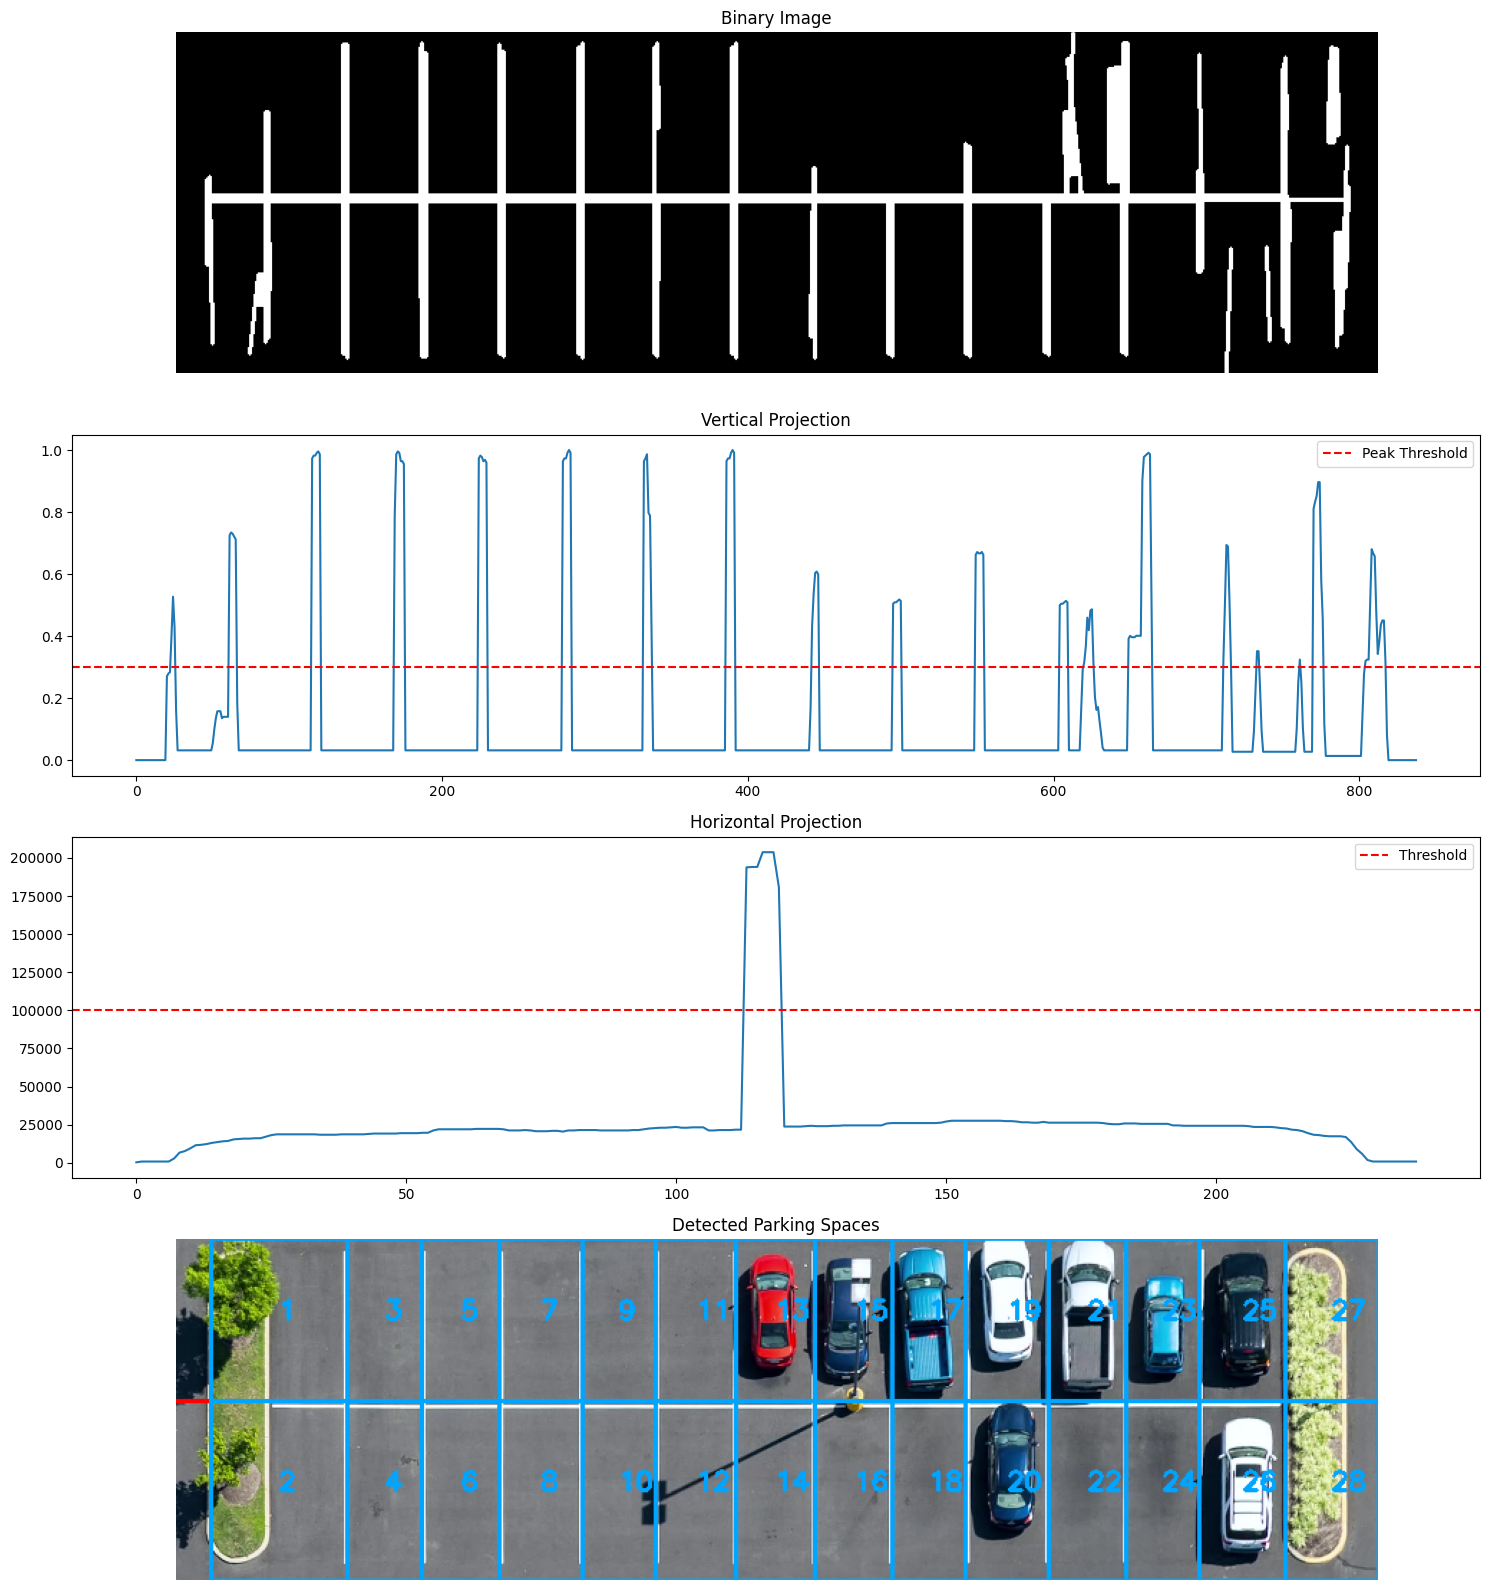


Analyzing Space 1:
Top half:
Space 1 Top - Variance: 1174.28, Mean Intensity: 117.46, Edge density: 0.194
Bottom half:
Space 1 Bottom - Variance: 1755.41, Mean Intensity: 124.44, Edge density: 0.143

Analyzing Space 2:
Top half:
Space 2 Top - Variance: 1509.07, Mean Intensity: 135.39, Edge density: 0.169
Bottom half:
Space 2 Bottom - Variance: 998.03, Mean Intensity: 131.86, Edge density: 0.118

Analyzing Space 3:
Top half:
Space 3 Top - Variance: 27.41, Mean Intensity: 123.76, Edge density: 0.003
Bottom half:
Space 3 Bottom - Variance: 55.92, Mean Intensity: 123.83, Edge density: 0.019

Analyzing Space 4:
Top half:
Space 4 Top - Variance: 622.58, Mean Intensity: 130.83, Edge density: 0.065
Bottom half:
Space 4 Bottom - Variance: 121.22, Mean Intensity: 124.25, Edge density: 0.025

Analyzing Space 5:
Top half:
Space 5 Top - Variance: 493.57, Mean Intensity: 130.65, Edge density: 0.018
Bottom half:
Space 5 Bottom - Variance: 607.98, Mean Intensity: 129.52, Edge density: 0.027

Analyzin

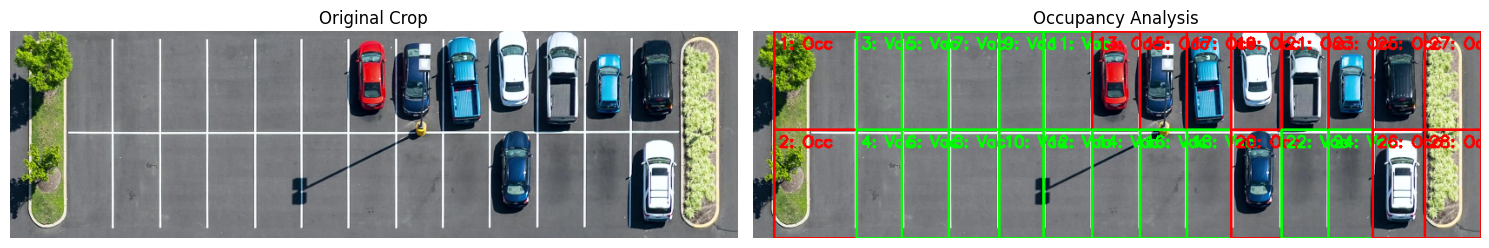

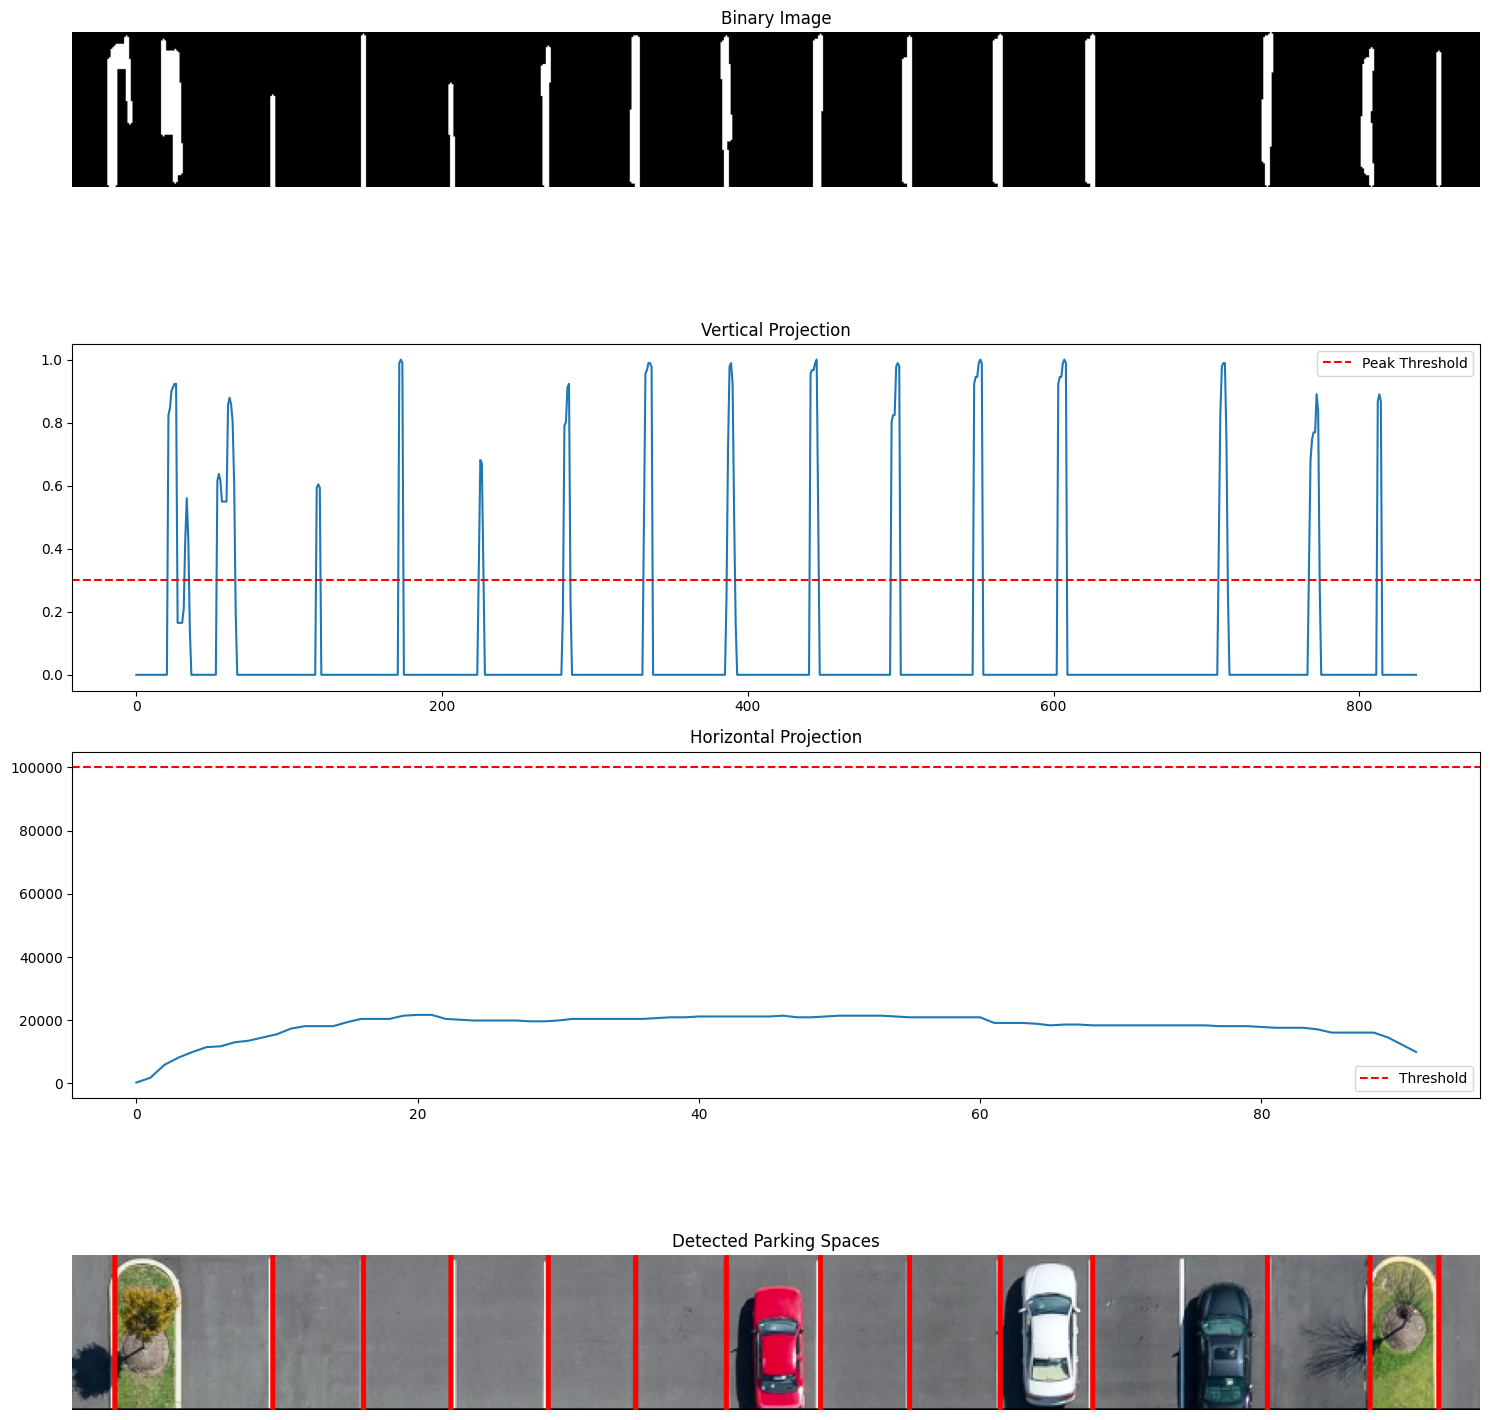


Analyzing Space 1:
Top half:
Space 1 Top - Variance: 1410.94, Mean Intensity: 129.66, Edge density: 0.154
Bottom half:
Space 1 Bottom - Variance: 1502.16, Mean Intensity: 135.00, Edge density: 0.157

Analyzing Space 2:
Top half:
Space 2 Top - Variance: 389.69, Mean Intensity: 129.85, Edge density: 0.036
Bottom half:
Space 2 Bottom - Variance: 746.27, Mean Intensity: 131.99, Edge density: 0.058

Analyzing Space 3:
Top half:
Space 3 Top - Variance: 289.54, Mean Intensity: 128.10, Edge density: 0.018
Bottom half:
Space 3 Bottom - Variance: 675.54, Mean Intensity: 128.20, Edge density: 0.040

Analyzing Space 4:
Top half:
Space 4 Top - Variance: 966.34, Mean Intensity: 133.23, Edge density: 0.049
Bottom half:
Space 4 Bottom - Variance: 1397.51, Mean Intensity: 135.27, Edge density: 0.071

Analyzing Space 5:
Top half:
Space 5 Top - Variance: 107.99, Mean Intensity: 125.74, Edge density: 0.036
Bottom half:
Space 5 Bottom - Variance: 484.97, Mean Intensity: 126.93, Edge density: 0.040

Analyz

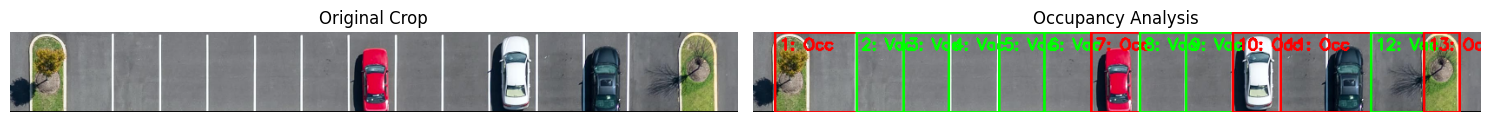

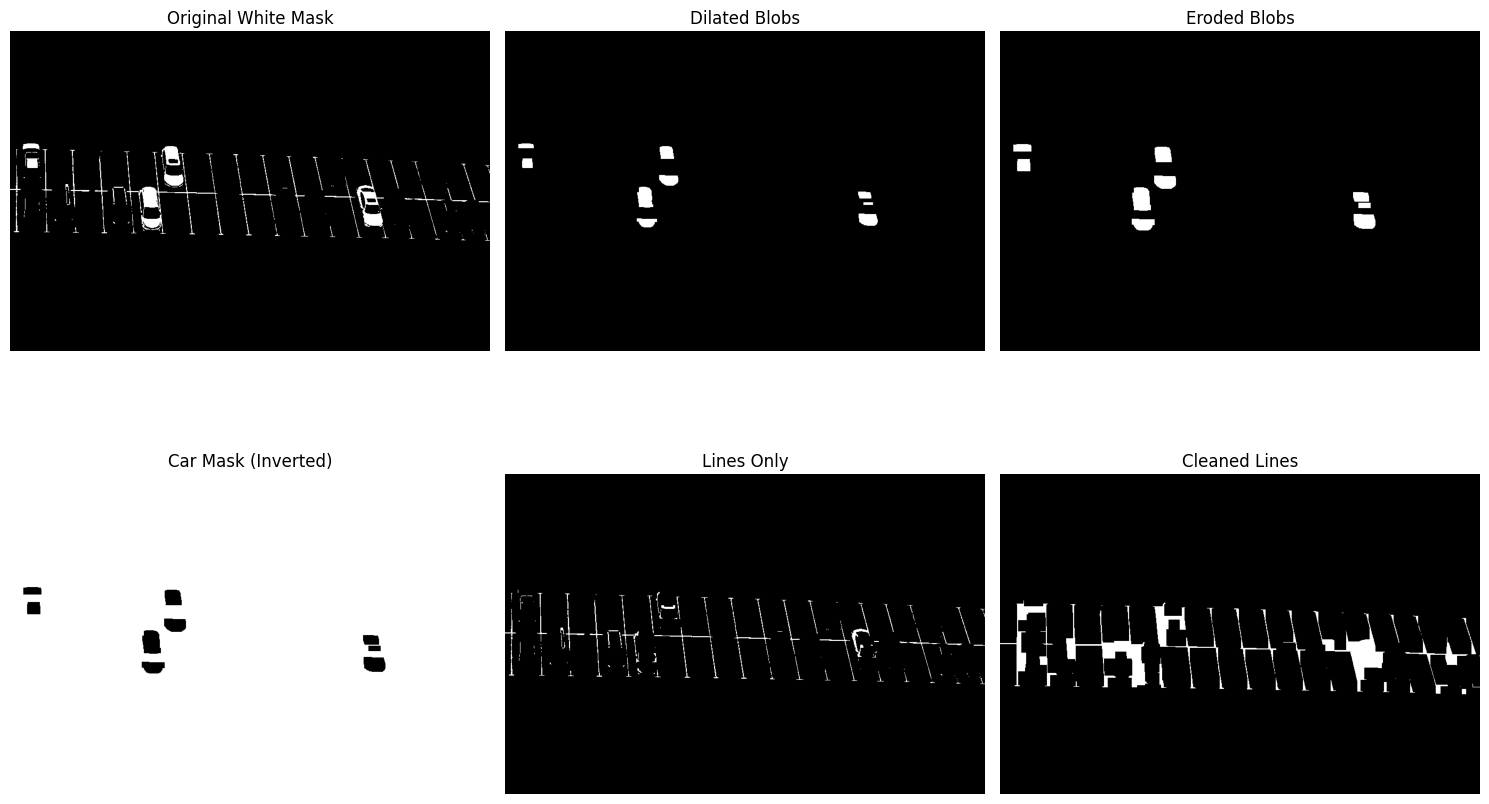

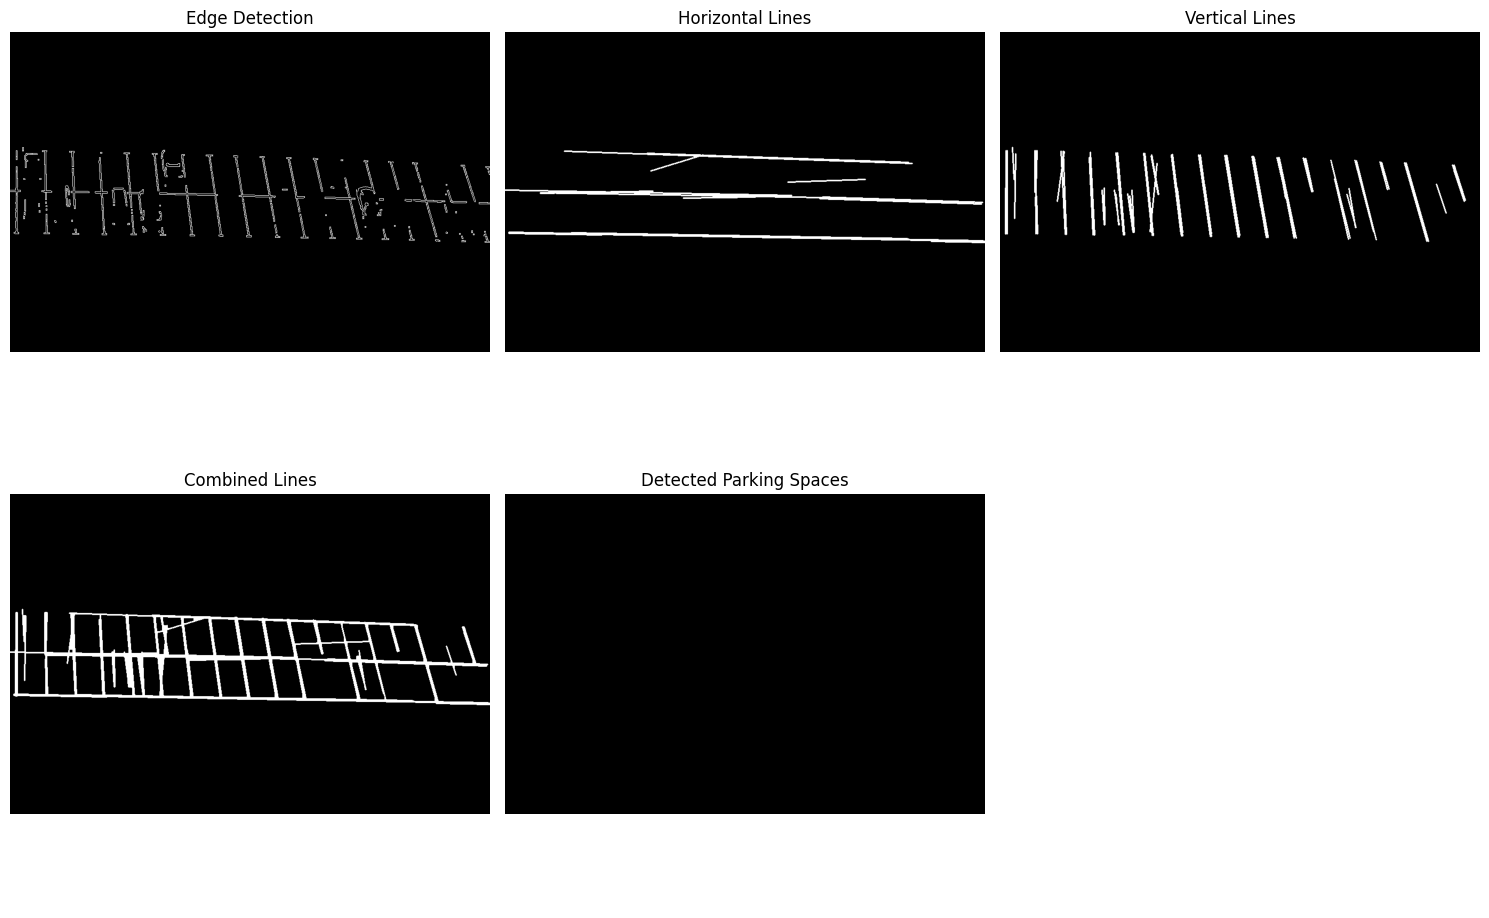

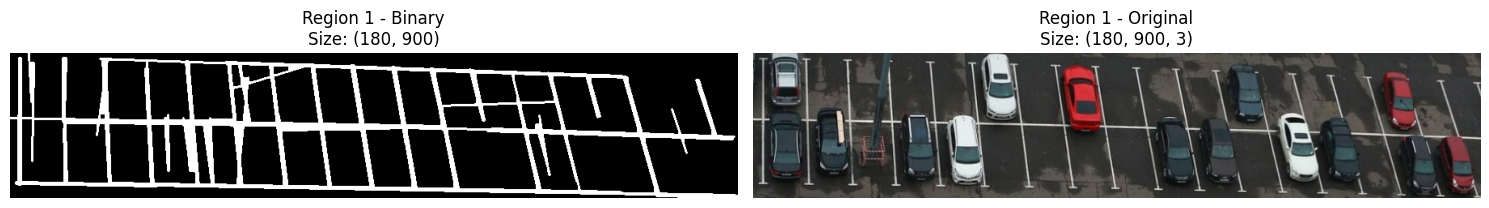

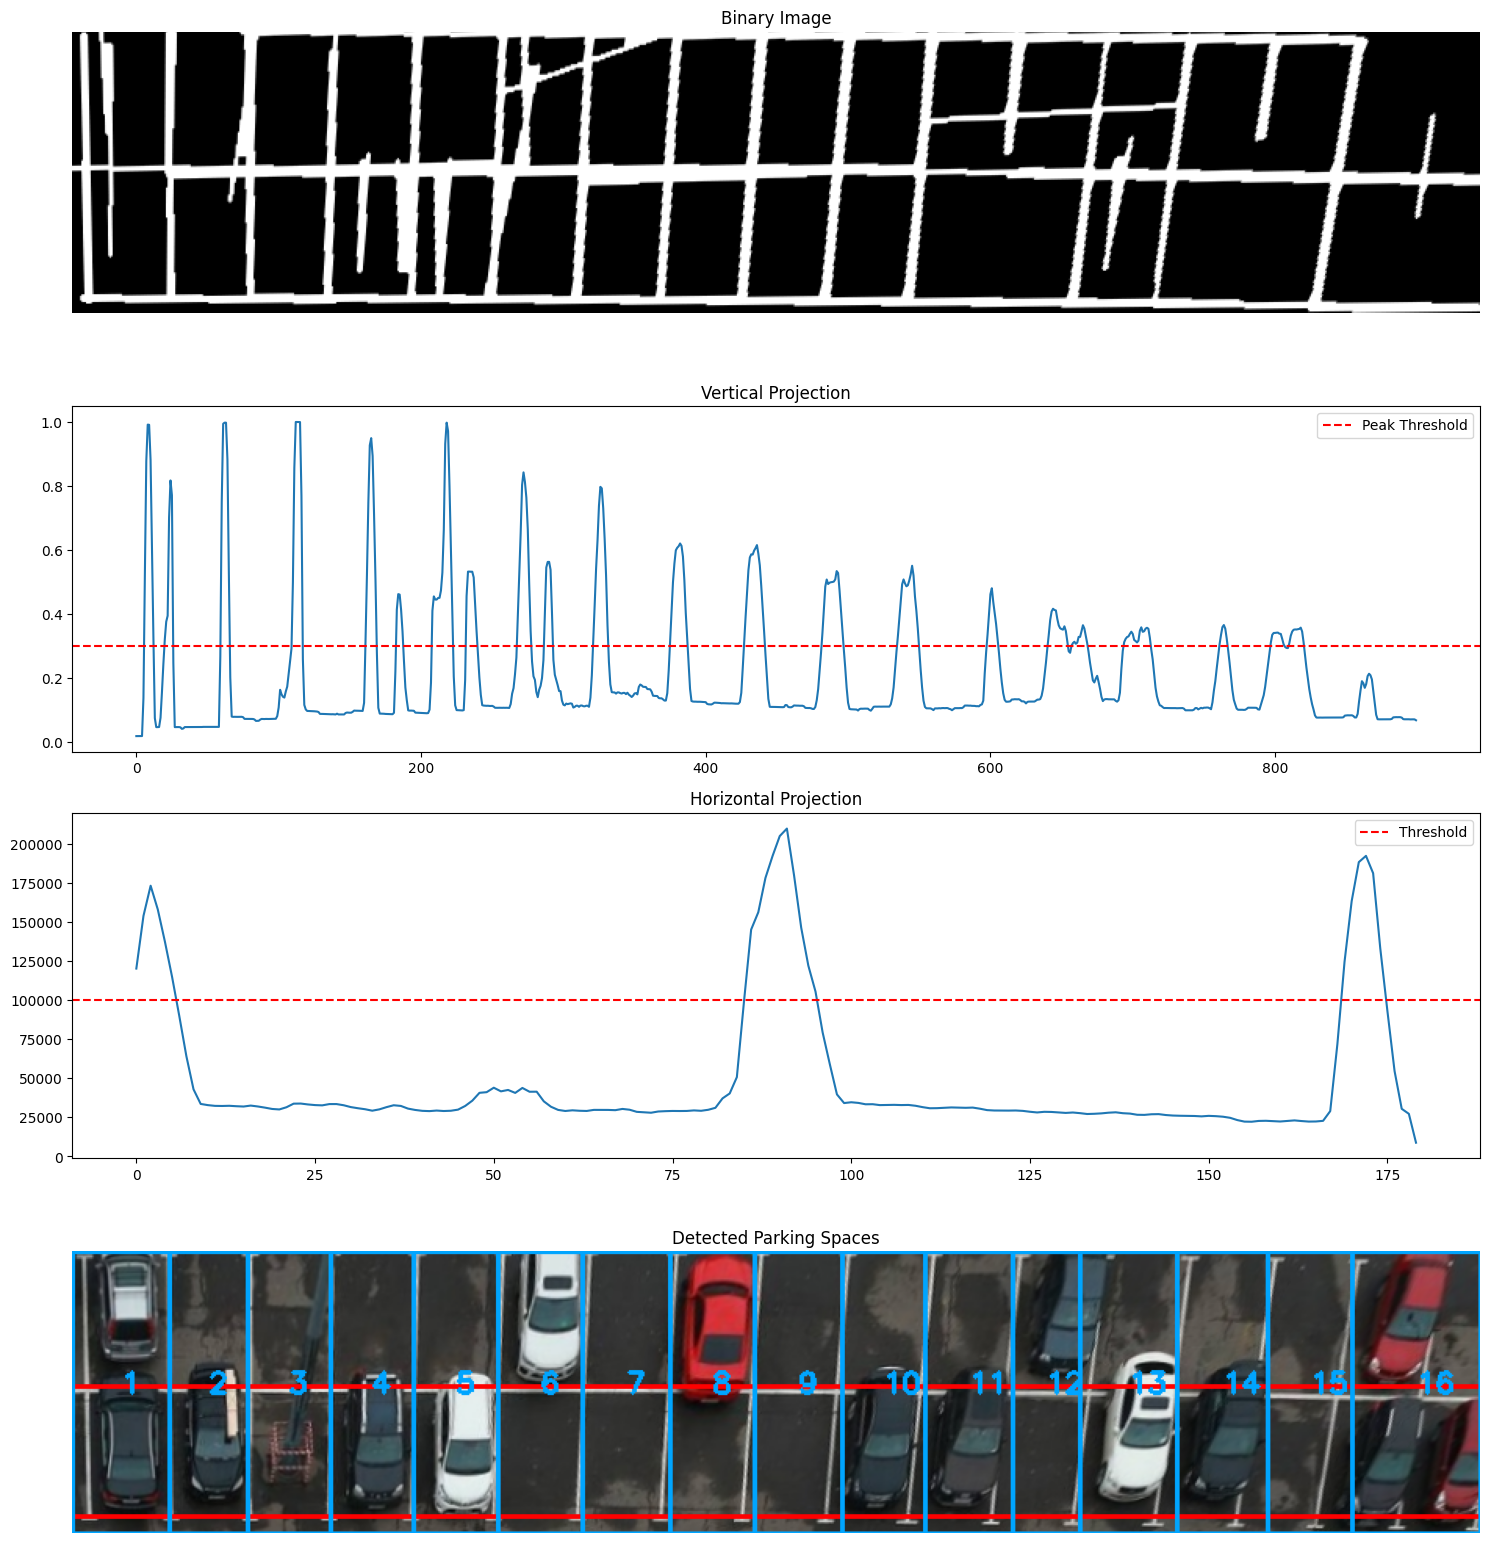


Analyzing Space 1:
Top half:
Space 1 Top - Variance: 3234.84, Mean Intensity: 90.92, Edge density: 0.227
Bottom half:
Space 1 Bottom - Variance: 1169.97, Mean Intensity: 58.12, Edge density: 0.153

Analyzing Space 2:
Top half:
Space 2 Top - Variance: 1189.55, Mean Intensity: 59.03, Edge density: 0.171
Bottom half:
Space 2 Bottom - Variance: 1006.00, Mean Intensity: 53.38, Edge density: 0.163

Analyzing Space 3:
Top half:
Space 3 Top - Variance: 437.62, Mean Intensity: 54.96, Edge density: 0.066
Bottom half:
Space 3 Bottom - Variance: 1160.45, Mean Intensity: 76.14, Edge density: 0.142

Analyzing Space 4:
Top half:
Space 4 Top - Variance: 2750.15, Mean Intensity: 72.99, Edge density: 0.166
Bottom half:
Space 4 Bottom - Variance: 934.19, Mean Intensity: 47.14, Edge density: 0.107

Analyzing Space 5:
Top half:
Space 5 Top - Variance: 782.69, Mean Intensity: 71.78, Edge density: 0.116
Bottom half:
Space 5 Bottom - Variance: 972.55, Mean Intensity: 66.43, Edge density: 0.110

Analyzing Spa

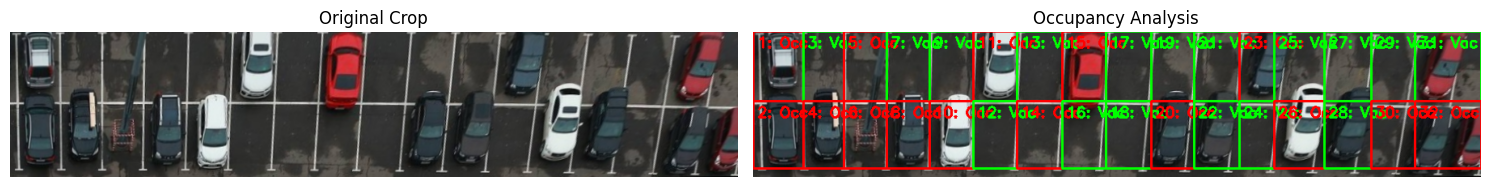

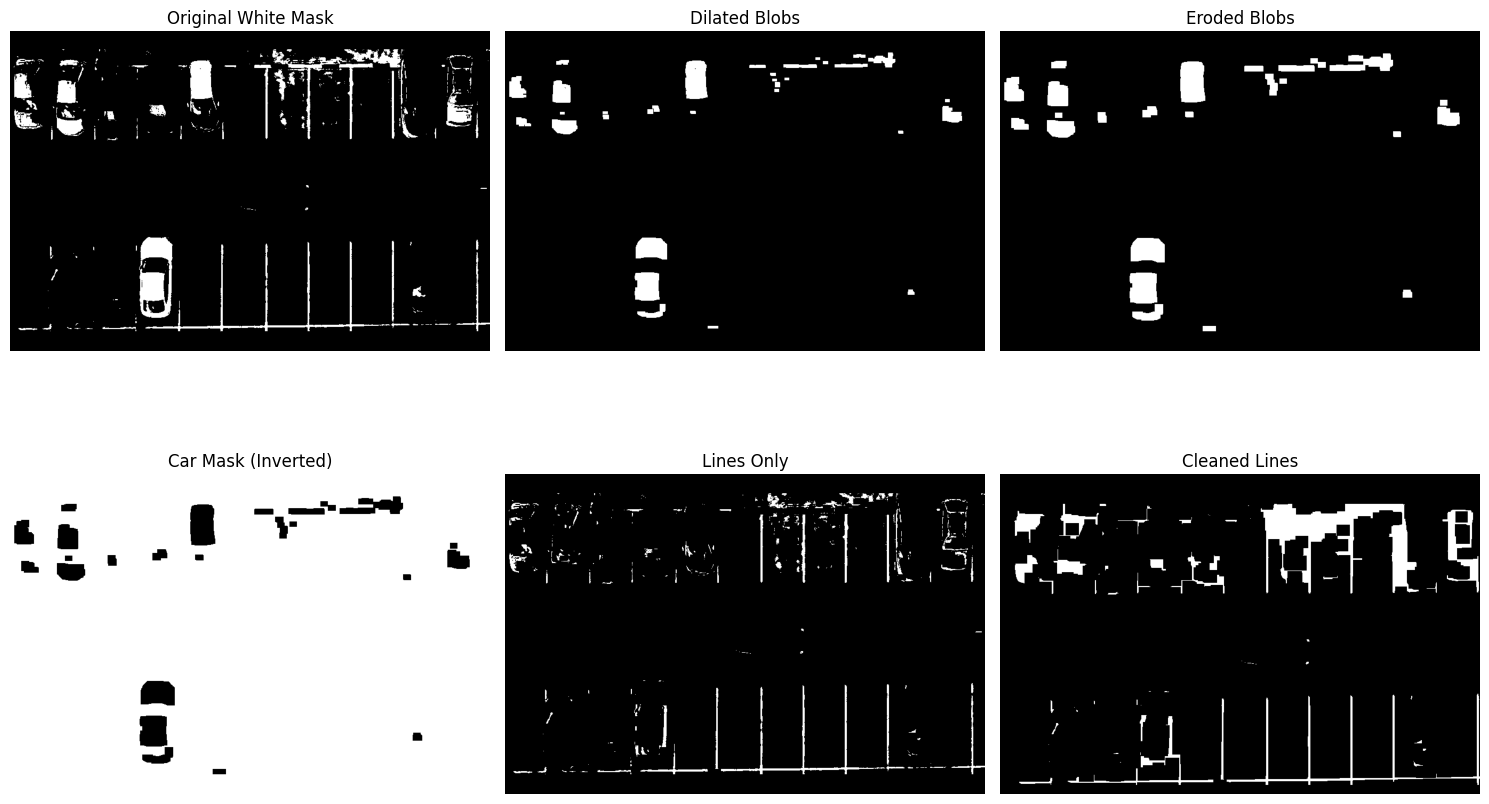

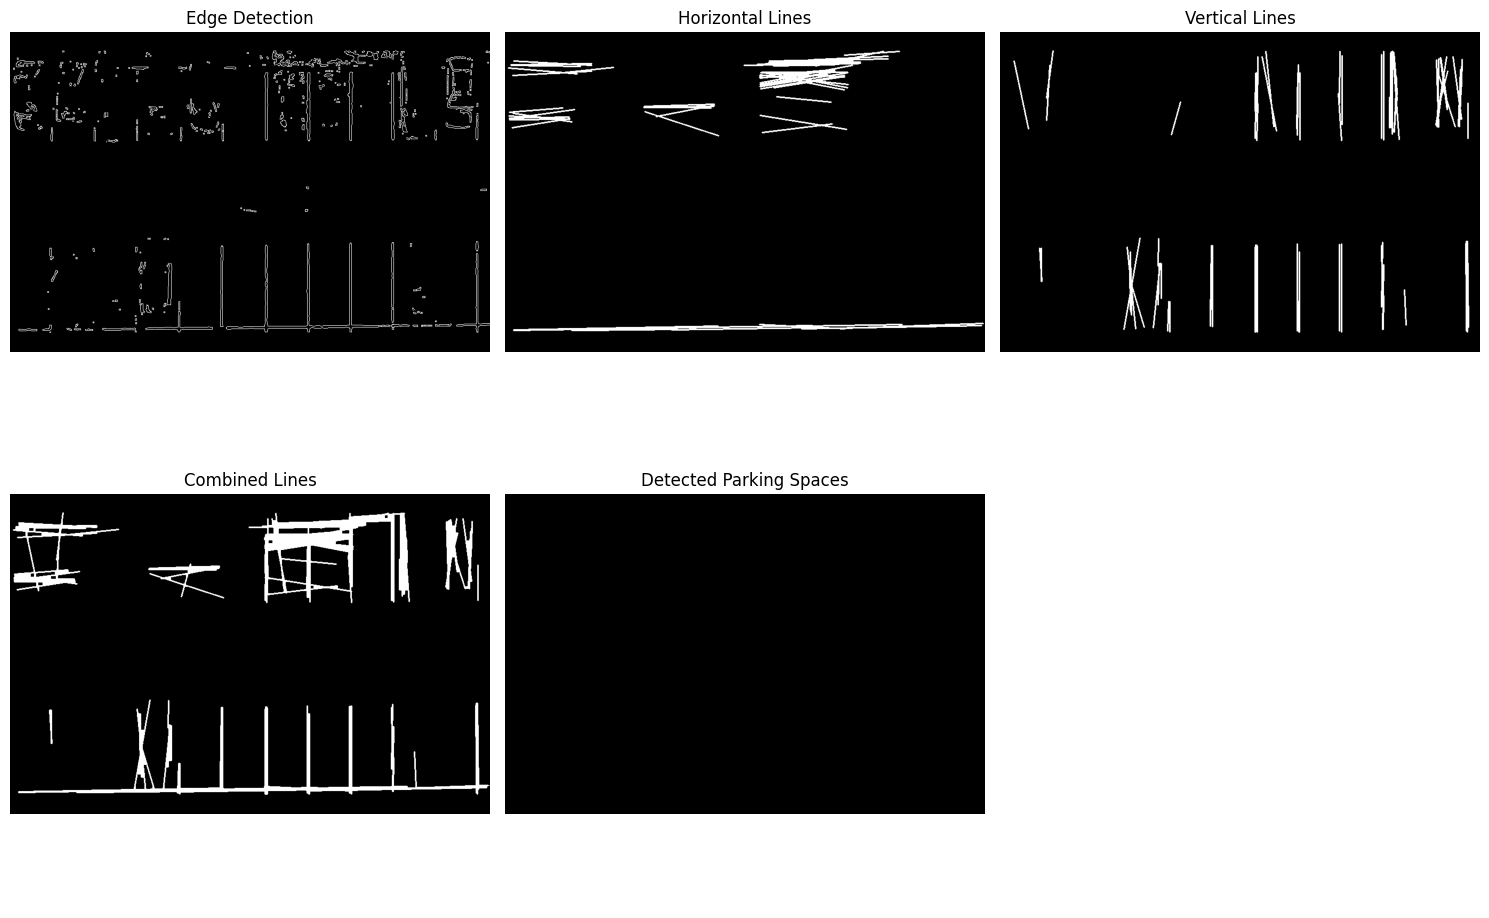

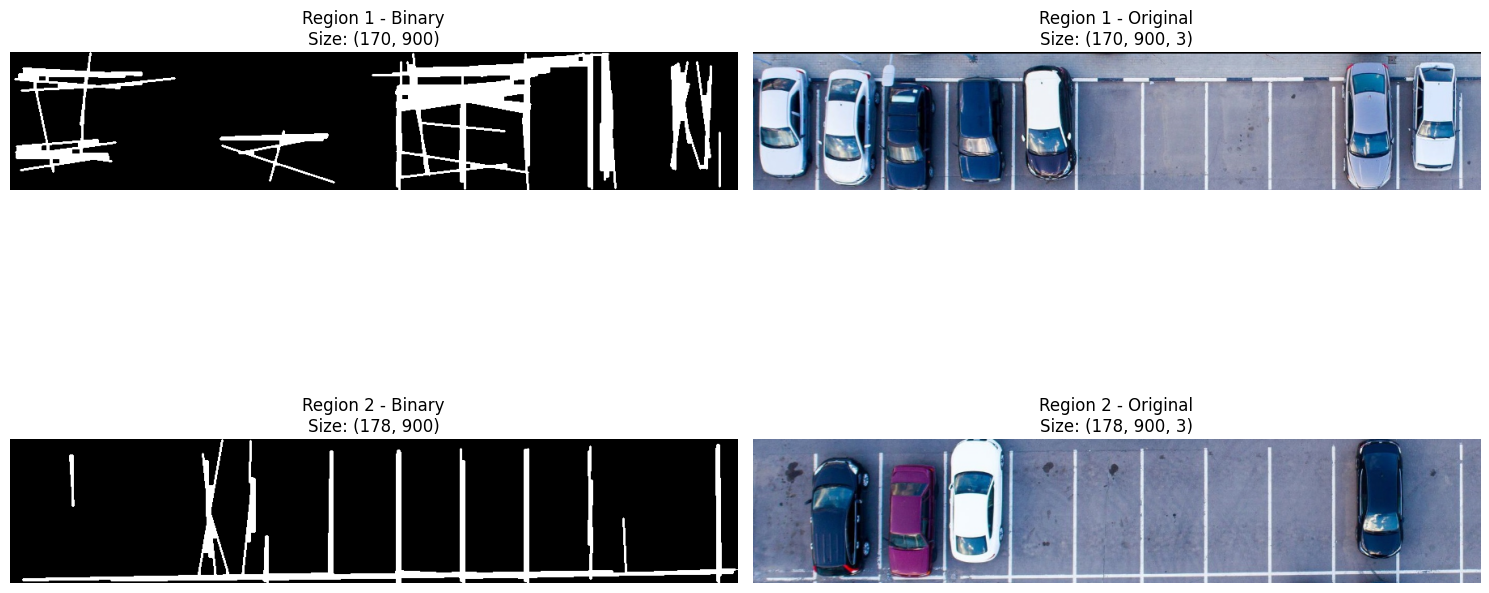

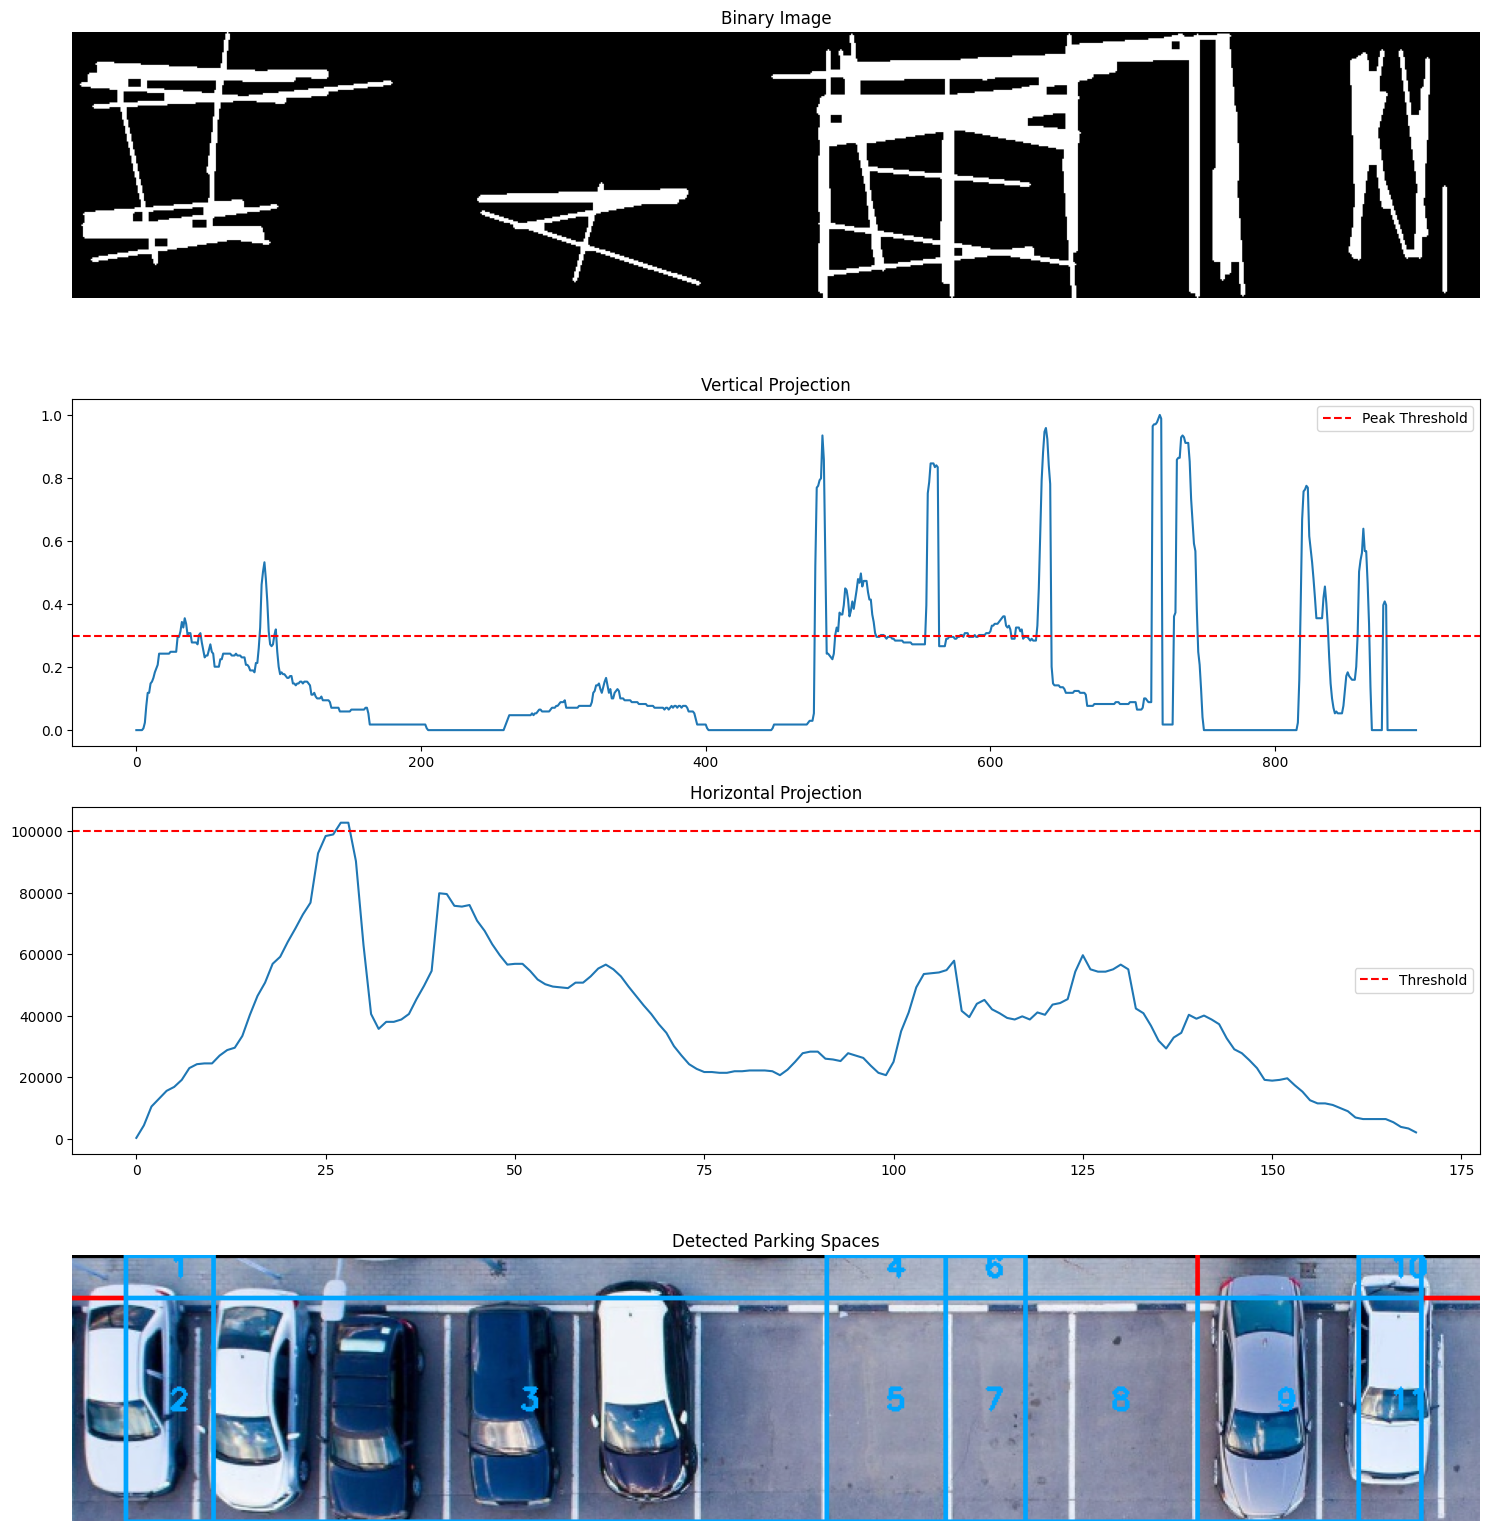


Analyzing Space 1:
Top half:
Space 1 Top - Variance: 3161.11, Mean Intensity: 130.33, Edge density: 0.093
Bottom half:
Space 1 Bottom - Variance: 1447.13, Mean Intensity: 162.93, Edge density: 0.079

Analyzing Space 2:
Top half:
Space 2 Top - Variance: 5086.58, Mean Intensity: 107.98, Edge density: 0.185
Bottom half:
Space 2 Bottom - Variance: 4668.26, Mean Intensity: 132.01, Edge density: 0.163

Analyzing Space 3:
Top half:
Space 3 Top - Variance: 3016.28, Mean Intensity: 123.16, Edge density: 0.101
Bottom half:
Space 3 Bottom - Variance: 1297.07, Mean Intensity: 147.71, Edge density: 0.055

Analyzing Space 4:
Top half:
Space 4 Top - Variance: 5770.75, Mean Intensity: 110.66, Edge density: 0.111
Bottom half:
Space 4 Bottom - Variance: 3408.74, Mean Intensity: 103.21, Edge density: 0.141

Analyzing Space 5:
Top half:
Space 5 Top - Variance: 3936.67, Mean Intensity: 146.28, Edge density: 0.082
Bottom half:
Space 5 Bottom - Variance: 25.33, Mean Intensity: 178.20, Edge density: 0.000

A

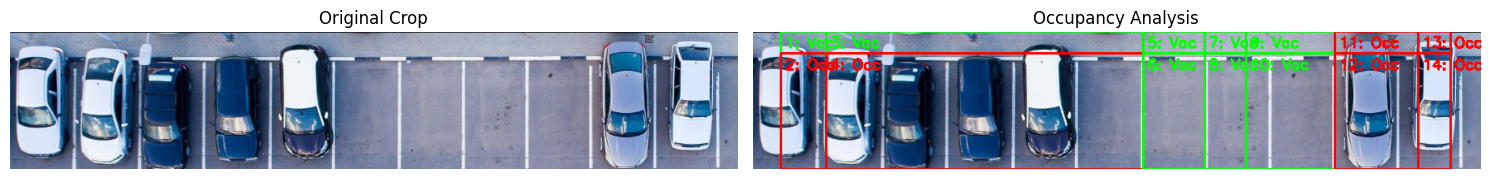

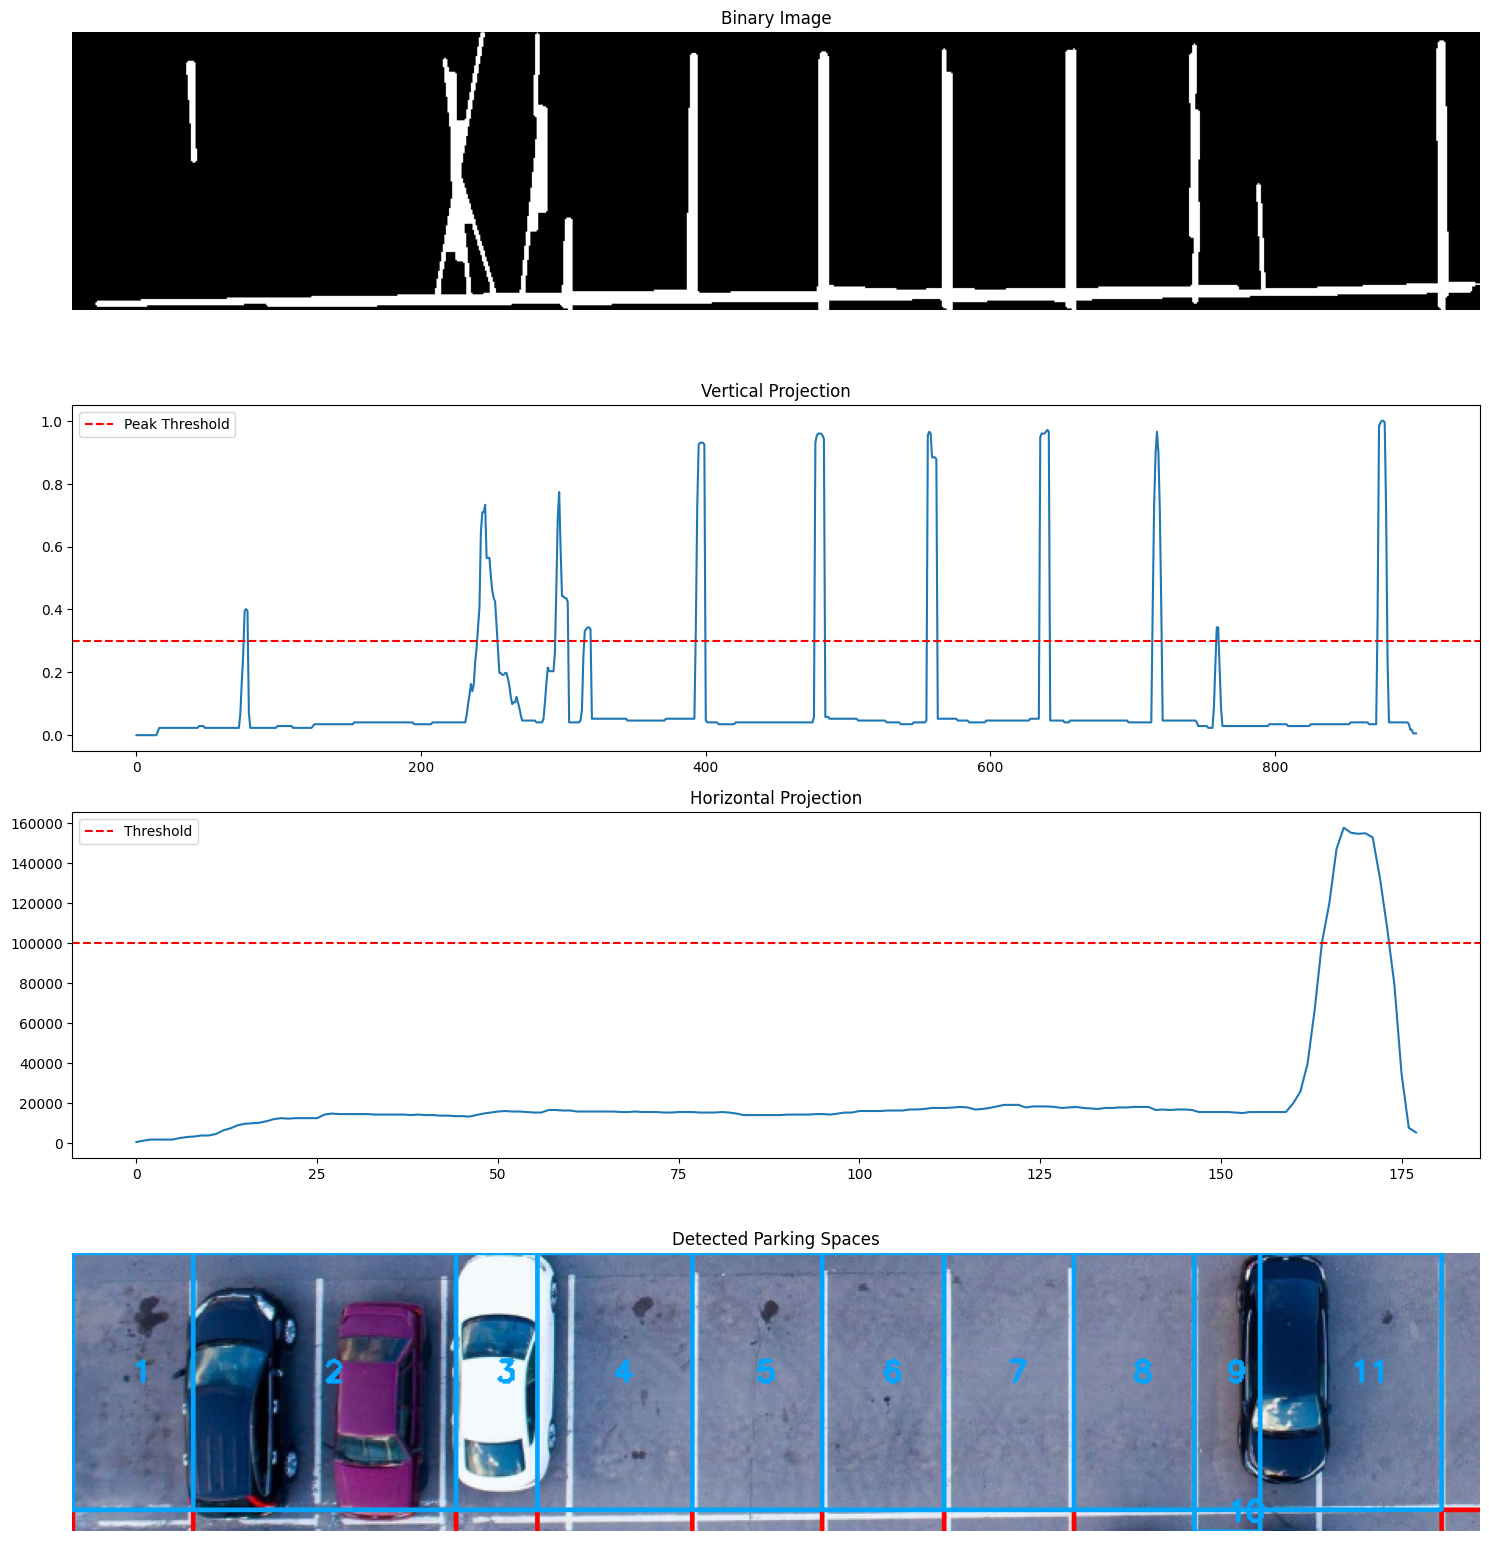


Analyzing Space 1:
Top half:
Space 1 Top - Variance: 455.75, Mean Intensity: 113.97, Edge density: 0.063
Bottom half:
Space 1 Bottom - Variance: 291.99, Mean Intensity: 113.23, Edge density: 0.036

Analyzing Space 2:
Top half:
Space 2 Top - Variance: 1614.32, Mean Intensity: 78.59, Edge density: 0.102
Bottom half:
Space 2 Bottom - Variance: 1512.99, Mean Intensity: 58.99, Edge density: 0.144

Analyzing Space 3:
Top half:
Space 3 Top - Variance: 6458.96, Mean Intensity: 186.44, Edge density: 0.127
Bottom half:
Space 3 Bottom - Variance: 5080.82, Mean Intensity: 188.10, Edge density: 0.117

Analyzing Space 4:
Top half:
Space 4 Top - Variance: 1651.40, Mean Intensity: 126.33, Edge density: 0.055
Bottom half:
Space 4 Bottom - Variance: 1157.19, Mean Intensity: 136.37, Edge density: 0.071

Analyzing Space 5:
Top half:
Space 5 Top - Variance: 475.02, Mean Intensity: 130.77, Edge density: 0.045
Bottom half:
Space 5 Bottom - Variance: 418.72, Mean Intensity: 141.99, Edge density: 0.029

Analy

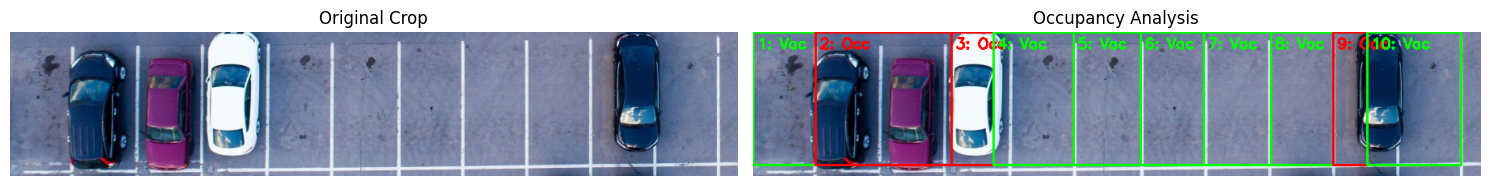

In [359]:
# Main processing loop
image_dir = 'c:/Users/Patrick/Documents/EmbeddedImageProcessing/Mini-Project/Mini_project_images/medium/*'
image_files = [file for file in glob(image_dir, recursive=True) if file.endswith(('.jpg', '.png'))]
all_results = []    

for i, file in enumerate(image_files):
    original_img = cv2.imread(file)
    standardized = standardize_image(original_img)
    parking_spaces = detect_white_lines(standardized)
    parking_lines = detect_parking_lines(parking_spaces)
    
    binary_crops, original_crops, crop_coordinates = crop_parking_regions(parking_lines, standardized)

    if i == 1:
        warped_image = get_birds_eye_view(binary_crops[0])
        # Resize warped_image to match binary_crops[0]
        warped_image = cv2.resize(warped_image, 
                                dsize=binary_crops[0].shape[::-1], 
                                interpolation=cv2.INTER_LINEAR) 

        binary_crops[0] = warped_image 

        warped_original = get_birds_eye_view(original_crops[0])
        # Resize warped_original to match original_crops[0] 
        warped_original = cv2.resize(warped_original, 
                             dsize=(original_crops[0].shape[1], original_crops[0].shape[0]), 
                             interpolation=cv2.INTER_LINEAR)
        original_crops[0] = warped_original

    for binary_crop, original_crop in zip(binary_crops, original_crops):
        # Get the peaks from detect_parking_spaces
        v_peaks, h_peaks, _  = detect_parking_spaces(binary_crop, original_crop)
        # Use those peaks directly to extract spots
        spots = extract_parking_spots(original_crop, v_peaks, h_peaks)
        cv2.waitKey(1000)
        occupancy_results, annotated_img = analyze_parking_spot_occupancy(original_crop, spots)
        all_results.extend(occupancy_results)